<a href="https://colab.research.google.com/github/LeeJeongWoon-Workout/Reinforcement_Learning_Projct/blob/main/cartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Bernoulli
from torch.autograd import Variable
from itertools import count
import matplotlib.pyplot as plt
import numpy as np
import gym
import pdb

In [63]:
class PolicyNet(nn.Module):
    def __init__(self):
        super(PolicyNet, self).__init__()

        self.fc1 = nn.Linear(4, 24)
        self.fc2 = nn.Linear(24, 36)
        self.fc3 = nn.Linear(36, 1)  # Prob of Left

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        #베르누이 함수에 넣기 위해 input이 0~1사이의 값이 되어야 한다.
        x = F.sigmoid(self.fc3(x))
        return x

'''State of CartPole
카트의 위치
카트의 속력
막대기의 각도
막대기의 끝부분(상단) 속도
'''

'State of CartPole\n카트의 위치\n카트의 속력\n막대기의 각도\n막대기의 끝부분(상단) 속도\n'

In [64]:
# Plot duration curve: 
episode_durations = []
def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.FloatTensor(episode_durations)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated

In [65]:
def main():

    # Parameters
    num_episode = 5000
    batch_size = 5
    learning_rate = 0.01
    gamma = 0.99

    env = gym.make('CartPole-v0')
    policy_net = PolicyNet()
    optimizer = torch.optim.RMSprop(policy_net.parameters(), lr=learning_rate)

    # Batch History
    state_pool = []
    action_pool = []
    reward_pool = []
    steps = 0


    for e in range(num_episode):
        #env를 초기화 한다.
        state = env.reset()
        state = torch.from_numpy(state).float()
        state = Variable(state)
        #convert state to tensor variable
        
        # env.render(mode='rgb_array')

        for t in count():
            #각 State에 따른  Action의 확률
            probs = policy_net(state)
            m = Bernoulli(probs)
            action = m.sample()
            '''
            Draws binary random numbers (0 or 1) from a Bernoulli distribution.

            '''

            #행동이 정해진다 > env에 행위를 가한다 > 다음 상태와 보상이 피드백으로 주어진다.
            action = action.data.numpy().astype(int)[0]
            next_state, reward, done, _ = env.step(action)  #0 and 1 option possible
            # env.render(mode='rgb_array')

            # To mark boundarys between episodes
            if done:
                reward = 0
            # torch optim에 돌리기 위해서는 float형태로 변환해야 한다.
            state_pool.append(state)
            action_pool.append(float(action))
            reward_pool.append(reward)
            #단기 reward 후에 return 식을 만드는 데 필요한 정보들이다.
            state = next_state
            state = torch.from_numpy(state).float()
            state = Variable(state)

            steps += 1
#  one episode is finished recored durations in episode_durations list'''
            if done:
                episode_durations.append(t + 1)
                #visualization
                if e%500==0:
                  plot_durations()
                break
# batch 안에서 on-line learning 수행 batch gradient는 아님'''
        # Update policy
        if e > 0 and e % batch_size == 0:

            # Discount reward
            running_add = 0
            # 제공형식을 구현하기 위해 dynamic programming 도입 
            for i in reversed(range(steps)):
                if reward_pool[i] == 0:
                    running_add = 0
                else:
                    running_add = running_add * gamma + reward_pool[i]
                    reward_pool[i] = running_add

            # Normalize reward
            reward_mean = np.mean(reward_pool)
            reward_std = np.std(reward_pool)
            for i in range(steps):
                reward_pool[i] = (reward_pool[i] - reward_mean) / reward_std

            # Gradient Desent
            optimizer.zero_grad()
            for i in range(steps):
                state = state_pool[i]
                action = Variable(torch.FloatTensor([action_pool[i]]))
                reward = reward_pool[i]

                #상태의 확률은 신경망이 고정되어 있다면 input이 같다면 같은 값을 내보낸다. 이것이 신경망이 상태에 따라 확률을 부여하는 방식이다.
                probs = policy_net(state)
                m = Bernoulli(probs)
                loss= -m.log_prob(action) * reward  # Negtive score function x reward
                #optimization은 gradient의 반대방향으로 움직인다. 그런데 경사 상승법은 부호대로 움직여야 하므로 loss에 -를 붙여 경사 상승법으로 바꾼다.
                #sample 하나 하나에 대해서 gradient descent를 진행해 준다.
                loss.backward()

            optimizer.step()

            state_pool = []
            action_pool = []
            reward_pool = []
            steps = 0
            #step은 episode의 길이를 나타내므로 0으로 초기화 하고 다음 에피소드를 준비한다.
            # Gradient Descent 가 끝나면 모든 정보값을 초기화 한 후 다시 훈련을 진행한다.

# 왜 batch를 하지 않는가? episode 길이가 일정하지 않아 텐서에 담아서 기존의 batch gradient를 하기가 불가능하다.

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


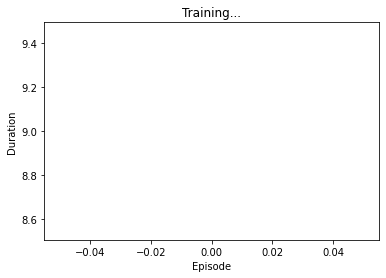

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


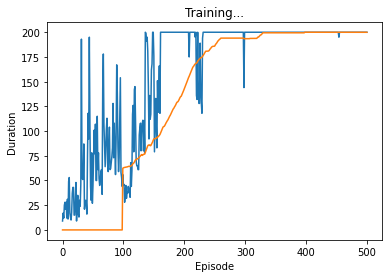

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


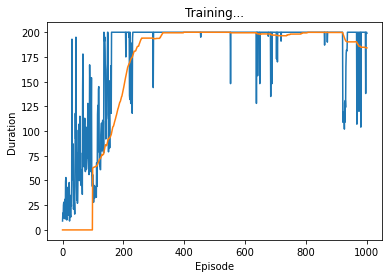

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


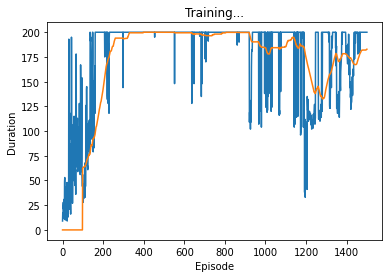

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


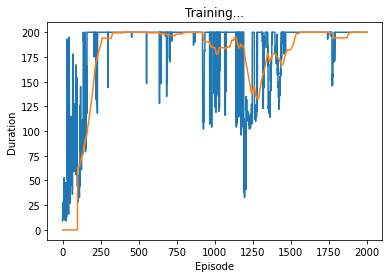

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


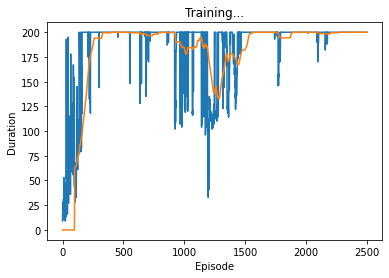

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


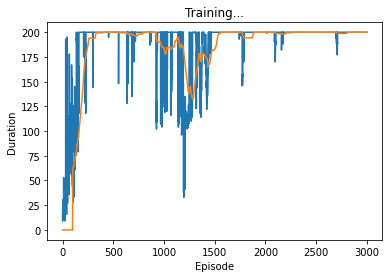

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


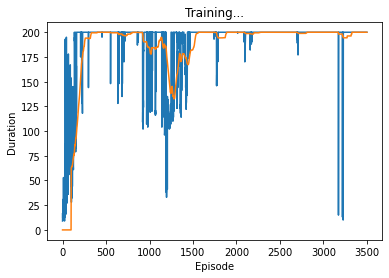

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


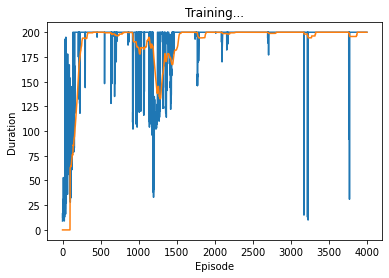

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


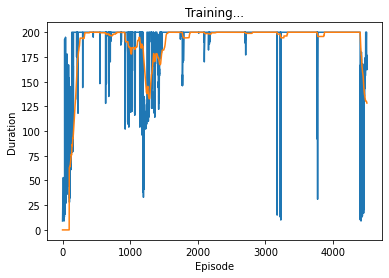

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


KeyboardInterrupt: ignored

In [66]:
if __name__ == '__main__':
    main()